In [ ]:
#import pickle
import requests
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

C:\Users\gabri\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [ ]:
def obter_cotacoes(moeda='GBP', data_inicio='01-01-2015', data_fim='10-07-2025'):
    url = f"https://olinda.bcb.gov.br/olinda/servico/PTAX/versao/v1/odata/" \
          f"CotacaoMoedaPeriodo(moeda=@moeda,dataInicial=@dataInicial,dataFinalCotacao=@dataFinalCotacao)?" \
          f"@moeda='{moeda}'&@dataInicial='{data_inicio}'&@dataFinalCotacao='{data_fim}'&" \
          f"$top=10000&$format=json"

    response = requests.get(url)
    data = response.json()['value']
    df = pd.DataFrame(data)
    df['dataHoraCotacao'] = pd.to_datetime(df['dataHoraCotacao'])
    df = df.sort_values('dataHoraCotacao')
    df = df[['dataHoraCotacao', 'cotacaoVenda']]
    df.columns = ['ds', 'y']

    df = df[df['y'].notnull()]
    df = df[df['y'] > 2]
    df = df[df['y'] < 15]

    df['ds'] = df['ds'].dt.date
    df = df.groupby('ds', as_index=False).mean()
    df['ds'] = pd.to_datetime(df['ds'])

    return df

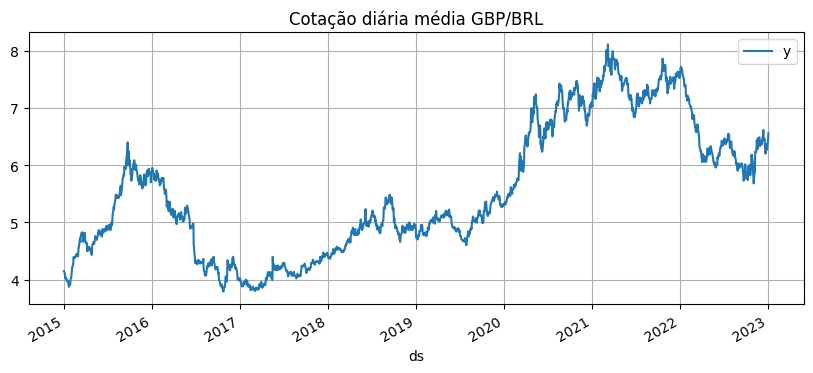

In [ ]:
df = obter_cotacoes()


df.plot(x='ds', y='y', title='Cotação diária média GBP/BRL', figsize=(10, 4))
plt.grid(True)
plt.show()

In [ ]:
model = Prophet(changepoint_prior_scale=0.0006)
model.fit(df)

11:40:03 - cmdstanpy - INFO - Chain [1] start processing
11:40:03 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
def converter_libras_para_reais(valor_libras, data_prevista):
    data_prevista = pd.to_datetime(data_prevista)
    dias_futuros = (data_prevista - df['ds'].max()).days

    if dias_futuros < 0:
        raise ValueError("Data fornecida está no passado.")

    future = model.make_future_dataframe(periods=dias_futuros + 1)
    forecast = model.predict(future)

    forecast['diff'] = abs(forecast['ds'] - data_prevista)
    linha = forecast.loc[forecast['diff'].idxmin()]
    cotacao = linha['yhat']
    return round(valor_libras * cotacao, 2), cotacao

In [ ]:
libras = 1
data = '2025-10-01'
valor_em_reais, cotacao = converter_libras_para_reais(libras, data)
print(f"Em {data}, £{libras} valerão aproximadamente R${valor_em_reais} (cotação prevista: R${cotacao:.2f})")

Em 2025-10-01, £1 valerão aproximadamente R$7.71 (cotação prevista: R$7.71)


In [ ]:
#with open("modelo_gbp_blr.pkl", "wb") as f:
    #pickle.dump(model, f)